# Ifremer product 1 altimeter swh, CCMP version 2 wsp, and WW3 modelled hs and wnd data climatologies 

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files 
import glob 
import cmocean.cm as cmo
from matplotlib import cm 

#my functions
from running_mean import running_mean
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from climatology_mean import clima_mean
from regional_clima import regional_clima
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. In addition, pick the resolution of the grid boxes which the climatologies will be computed from: 

In [4]:
nt = 8400 
nlon_i, nlat_i = 360, 133
nlon_c, nlat_c = 1440, 529
nlon_w, nlat_w = 720, 265
ngrid = 3
month = np.arange(1,13,1)

Set Ifremer filename and look at key variables and attributes

In [5]:
filename_i = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/bia_daily_binned_ifremer_data/all_sat_binned_swh_1992-08-23_2016-08-23.nc'

#set nc variable in order to read attributes and obtained data: 
nc_i = Dataset(filename_i, 'r')

#print key variables:
print(nc_i.variables.keys())

#longitude
for at in nc_i.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_i.variables['lon'].getncattr(at)))

#laitude
for at in nc_i.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_i.variables['lat'].getncattr(at)))
    
#time 
for at in nc_i.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_i.variables['time'].getncattr(at)))

odict_keys(['lat', 'lon', 'time', 'swh', 'swhcor', 'N'])
long_name : longitude in degrees east
units : degrees_east
add_offset : 0.0
scale_factor : 0.01
valid_range : [    0. 36000.]
long_name : latitude in degrees north
units : degrees_north
add_offset : 0.0
scale_factor : 0.01
valid_range : [-9000.  9000.]
long_name : time
units : days since 1900-1-1 0:0:0
add_offset : 0.0
scale_factor : 1.0
valid_range : [     0. 401767.]


Call Bia's Ifremer Product 1 daily binned data from the server

In [6]:
swh_i = nc_i.variables['swhcor'][:]
lon_i = nc_i.variables['lon'][:]
lat_i = nc_i.variables['lat'][:]
time_i = num2date(nc_i.variables['time'][:], nc_i.variables['time'].units) #convert time directly into datetime format instead of integer value time
nc_i.close()

KeyboardInterrupt: 

Restrict the time series from 1993 to 2015 for swh_cor 

In [ ]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time_i])

#creat boolean arrays and combine them: 
ind_92 = years != 1992
ind_16 = years != 2016
ind_time = ind_92*ind_16

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matirx along the time axis from swh
swh_i = np.compress(ind_time, swh_i, axis = 0)
time_i = time_i[ind_time] 
print(swh_i.shape,time_i.shape)

Begin by computing the monthly averaged swh over the entire earth and extract desired variables from dictionary

In [8]:
#set year and month 2D time arrays that correspond to the year and month at 
#which swh data point was collected (time series indice array for year and month)
months = np.array([m.month for m in time_i])
print(time_i.shape)

(8400,)


Begin by computing the monthly averaged swh over the entire earth and extract desired variables from dictionary

In [9]:
#climatology: 
swh_clima_i = clima_mean(date_time = time_i, data = swh_i, fill_val = 'mask')

#define desired variables: 
swh_mean_i = np.ma.array(swh_clima_i['mean'])
#swh_median_i = np.ma.array(swh_climatology['median'])
swh_std_i = np.ma.array(swh_clima_i['std'])
swh_var_i = np.ma.array(swh_clima_i['var'])
#swh_n_i = np.ma.array(swh_climatology['N'])

Delete unnecessary variables in order to minimize the memory use

In [10]:
del swh_i, time_i, swh_clima_i

Set CCMP2 filename and look at key variables and attributes

In [11]:
filename_c = sorted(glob.glob('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_*_high_res.nc'))

#set nc variable in order to read attributes and obtained data: 
nc_c = Dataset(filename_c[0], 'r')

#print key variables:
print(nc_c.variables.keys())

#longitude
for at in nc_c.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_c.variables['lon'].getncattr(at)))

#laitude
for at in nc_c.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_c.variables['lat'].getncattr(at)))
    
#time 
for at in nc_c.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_c.variables['time'].getncattr(at)))


odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call each data set and append the data from one year onto the end of the previous year 

In [12]:
#initialize 3D array and counters/counter array
wsp_c = np.ma.masked_all([nt, nlat_c, nlon_c])
time_array = []
i = 0
yc = 0
year_c = np.array([365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365])

#restrict filename from 1993 to 2015: 
filename_c = filename_c[0:23]

#loop through each filename to call data: 
for f in filename_c: 
    
    #set nc variable in order to read attributes and obtained data: 
    nc_wnd = Dataset(f, 'r')
    #call wind speed data
    wsp = nc_wnd.variables['wsp'][:]
    time_i = num2date(nc_wnd.variables['time'][:], nc_wnd.variables['time'].units)
    #place the wsp and time data into the 3D arrays
    wsp_c[i:i+year_c[yc],:,:] = wsp
    time_array.append([time_i])
    #year counters: 
    i +=year_c[yc]
    yc += 1
    

Initialize longitude and latitude variables as well as set time as a numpy array (from a list)

In [13]:
#initialize lon and lat 
lon_c = nc_c.variables['lon'][:]
lat_c = nc_c.variables['lat'][:]

#change time to a numpy array 
time_c = np.hstack(time_array)[0]

Use the deresolve function to bring the resolution from 0.25 to 1 degree for the CCMP2 data set 

In [14]:
#initialize 3D array: 
wsp_array_c = np.ma.masked_all([nt,nlat_i,nlon_i])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    wsp_c_day  = wsp_c[itime,:,:]
    #preform the deresolution via convolution 
    wsp_deres_c = running_mean(data = wsp_c_day, k_dim = [4, 4], task = 'deresolve', fill_val = 'none')
    #Save running mean wsp into 3D array: 
    wsp_array_c[itime,:,:] = wsp_deres_c
    

Begin by computing the monthly averaged swh over the entire earth and extract desired variables from dictionary

In [15]:
#compute climatology
wsp_clima_c = clima_mean(date_time = time_c, data = wsp_array_c, fill_val = 'mask')

In [16]:
#define desired variables 
wsp_mean_c = np.ma.array(wsp_clima_c['mean'])
#wsp_median_c = np.ma.array(wsp_climatology['median'])
wsp_std_c = np.ma.array(wsp_clima_c['std'])
wsp_var_c = np.ma.array(wsp_clima_c['var'])
#wsp_n_c = np.ma.array(wsp_climatology['N'])

Delete unnecessary variables in order to minimize the memory use

In [17]:
del wsp_array_c, wsp_c, time_c, wsp_clima_c

Set WW3 filename and look at key variables and attributes

In [18]:
filename_hs_w = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_hs_daily_binned_data_93_16.nc'
filename_wnd_w = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_wnd_daily_binned_data_93_16.nc'

#set nc variable in order to read attributes and obtained data: 
nc_hs_w = Dataset(filename_hs_w, 'r')
nc_wnd_w = Dataset(filename_wnd_w, 'r')


#print key variables:
print(nc_hs_w.variables.keys())
print(nc_wnd_w.variables.keys())

#longitude
for at in nc_hs_w.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_hs_w.variables['lon'].getncattr(at)))

#laitude
for at in nc_hs_w.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_hs_w.variables['lat'].getncattr(at)))
    
#time 
for at in nc_hs_w.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_hs_w.variables['time'].getncattr(at)))

odict_keys(['time', 'lon', 'lat', 'swh'])
odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1990-01-01 00:00:00
calendar : julian


Call Hs and WSP data from WW3 netcdf files 

In [19]:
swh_w = nc_hs_w.variables['swh'][:]
wsp_w = nc_wnd_w.variables['wsp'][:]
lat_w = nc_hs_w.variables['lat'][:]
lon_w = nc_hs_w.variables['lon'][:]
time_w = num2date(nc_hs_w.variables['time'][:], nc_hs_w.variables['time'].units)
nc_hs_w.close

<function Dataset.close>

Use the deresolve function to bring the resolution from 0.5 to 1 degree for the WW3 data set 

In [20]:
#initialize 3D array: 
swh_array_w = np.ma.masked_all([nt,nlat_i,nlon_i])
wsp_array_w = np.ma.masked_all([nt,nlat_i,nlon_i])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    swh_w_day = swh_w[itime,:,:]
    wsp_w_day  = wsp_w[itime,:,:]
    #preform the deresolution via convolution 
    swh_deres_w = running_mean(data = swh_w_day, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    wsp_deres_w = running_mean(data = wsp_w_day, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    #Save running mean wsp into 3D array: 
    swh_array_w[itime,:,:] = swh_deres_w
    wsp_array_w[itime,:,:] = wsp_deres_w
    

Call data only from January 1st, 1993 to December 31st, 2015 

In [21]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time_w])

#creat boolean arrays and combine them: 
ind_time = years != 2016

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matrix along the time axis from swh
swh_array_w = np.compress(ind_time, swh_array_w, axis = 0)
wsp_array_w = np.compress(ind_time, wsp_array_w, axis = 0)
print(swh_array_w.shape,wsp_array_w.shape)

#extract the time steps: 
time_w = time_w[ind_time]

(8400, 133, 360) (8400, 133, 360)


Begin by computing the monthly averaged swh over the entire earth

In [22]:
swh_clima_w = clima_mean(date_time = time_w, data = swh_array_w, fill_val = 'mask')
wsp_clima_w = clima_mean(date_time = time_w, data = wsp_array_w, fill_val = 'mask')

Set the variables to each of the dictionary entires 

In [23]:
#WW3 swh: 
swh_mean_w = np.ma.array(swh_clima_w['mean'])
#swh_median_w = np.ma.array(swh_clima_w['median'])
swh_std_w = np.ma.array(swh_clima_w['std'])
swh_var_w = np.ma.array(swh_clima_w['var'])
#swh_n_w = np.ma.array(swh_clima_w['N'])

#WW3 wsp
wsp_mean_w = np.ma.array(wsp_clima_w['mean'])
#wsp_median_w = np.ma.array(wsp_clima_w['median'])
wsp_std_w = np.ma.array(wsp_clima_w['std'])
wsp_var_w = np.ma.array(wsp_clima_w['var'])
#wsp_n_w = np.ma.array(wsp_clima_w['N'])

Delete unnecessary variable

In [24]:
del swh_array_w, wsp_array_w, swh_w, wsp_w, swh_clima_w, wsp_clima_w

Convert the standard deviation to variance 

In [25]:
swh_var_test_i = (swh_std_i)**2
wsp_var_test_c = (wsp_std_c)**2
swh_var_test_w = (swh_std_w)**2
wsp_var_test_w = (wsp_std_w)**2

#compare to other variance calculation:
print(np.any(swh_var_test_i == swh_var_i))
print(np.any(wsp_var_test_c == wsp_var_c))
print(np.any(swh_var_test_w == swh_var_w))
print(np.any(wsp_var_test_w == wsp_var_w))

True
True
True
True


Set the dimensions of the subplot figure and whether the EBR is in the southern or northern hemisphere

In [26]:
n_row = 2
n_coln = 2
location = ['SH', 'east']
ngrid = 4

#### The following are the coordinates of the grid boxes evaluated at each EBR:

1) California: 

    a) North California: lon_grid => range(228,234,4)
                         lat_grid => range(98,104,4)
                         
    b) Southern California: lon_grid => range(232,238,4)
                            lat_grid => range(92,100,4)
    
    c)Western Australia: lon_grid => range(35,41,4)
                         lat_grid => range(104, 112,4)
                   
    d) South Caribbean: lon_grid => range(80,81,4)
                        lat_grid => range(280,290,4)
                        
    e) North Africa: lon_grid => range(335,340,4)
                     lat_grid => range(87,92,4)
                     
    f) South Africa (Nigeria) : lon_grid => range(7,12,4)
                                lat_grid => range(32,37,4)
                                
    g) Central West South America : lon_grid => range(280,285,4)
                                    lat_grid => range(30,36,4)
                  
    f) Arabian Sea: lon_grid => range(55,60,4)
                    lat_grid => range(71,76,4)

In [27]:
def regional_clima(data_mean, data_var, lon, lat, lon_grid, lat_grid, ngrid, dof, loc):

    """
    regional_clima(data_mean, data_var, lon, lat, lon_gird, lat_grid, ngrid, dof, loc)
    
        Function to compute the regional climatology from seasonally averaged data with its variance over the time period for a specified sized grid and location on earth
        
        Parameters 
        ----------
        data_mean : Seasonally averaged data with the following dimensions in 2D masked geospatial arrays:
                      e.g : data_mean.shape = (ntime, nlat, nlon) = (4, 133, 360)
                    Seasons are defined as: 
                      Winter = DJF
                      Spring = MAM
                      Summer = JJA
                      Fall = SON
        date_var : Seasonally averaged data's variance with the following dimensions in 2D masked geospatial arrays:
                      e.g : data_var.shape = (ntime, nlat, nlon) = (4, 133, 360)
        lon : longitude vector 
                e.g. : lon = np.arange(0, 360, 1)
        lat : latitude vector 
                e.g. : lon = np.arange(-66, 66, 1)
        lon_grid : initial longitude grid point to compute the regional climatology 
                     e.g. : lon_grid = 230
        lat_grid : initial latitude grid point to compute the regional climatology
                     e.g. : lon_grid = 230
        ngrid : The step amount of grid point that the regional climatology will average over 
                  e.g. : n_grid = 2
        dof : degrees of freedom (used to compute standard deviation of the mean) 
               e.g. : dof = 23
        loc : specifies if the regional climatology is in the northern or southern hemisphere or if it is east or west of the prime meridinal. 
               e.g : loc = [loc_lat, loc_lon] loc[0] = 'NH' or loc[0] = 'SH' and loc[1] = 'west' or loc[1] = 'east'
        
        Returns
        -------
        
        data_reg_mean : regional climatology averaged data 
                         e.g. data_reg_mean.shape = (1,12)
        data_reg_stdm : regional climatology averaged data's standard deviation of the mean
                         e.g. data_reg_stdm.shape = (1,12)
        hfit : least square fit model from a 5 parameter model (mean, annual cycle, semi-annual cycle)
        residual : model - data 
        grid_coordinates : indices from longitude and latitude which the climatology is computed for
        
        Libraries necessary to run function
        -----------------------------------
        import numpy as np
        from unweighted_least_square_fit import least_square_fit 
    
    
    """

    #import libraries
    import numpy as np
    from unweighted_least_square_fit import least_square_fit

    #case 1: west of prime meridian
    if loc[1] == 'west':
        loc_lon = 360
    #case 2: east of prime meridian
    elif loc[1] == 'east':
        loc_lon = 0

    #latitude and longitude grid points that will be averaged over: 
    lat_grid_i = lat[lat_grid]
    lat_grid_f = lat[lat_grid+ngrid-1]
    lon_grid_i = lon[lon_grid]-loc_lon
    lon_grid_f = lon[lon_grid+ngrid-1]-loc_lon
    grid_cor = [lat_grid_i, lat_grid_f, lon_grid_i, lon_grid_f]

    #call mean and variance data from grid box indices:
    data_grid_mean = data_mean[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
    data_grid_var = data_var[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]

    #average over the region along the column and depth dimension of the 3D array (the row axis is the time dimension): 
    data_reg_mean = np.ma.mean(np.ma.mean(data_grid_mean, axis = 1, dtype=np.float64), axis = 1)

    #compute the average variance over the region 
    data_reg_var = np.ma.mean(np.ma.mean(data_grid_var, axis = 1, dtype=np.float64), axis = 1)

    #compute the standard error of the mean assuming that degrees of freedom N = 23 years
    data_reg_stdm = np.sqrt(data_reg_var)/np.sqrt(dof)

    #compute the least square fit: 
    hfit, x_data = least_square_fit(data = data_reg_mean, trend = 'sinusoidal',
                                           parameters = 5, period = 12, fill_val = 'mask')

    #compute the residue between the model and observed SWH data:
    residual = hfit - data_reg_mean

    #Case 1: Southern hemisphere region
    if loc[0] == 'SH':

        #In the southern hemisphere, shift the time series over such that summer months of Dec, Jan, and Feb are center of figure:    
        data_reg_mean = np.reshape(np.ma.array([data_reg_mean[6:13], data_reg_mean[0:6]]), (1,12))[0]
        data_reg_stdm = np.reshape(np.ma.array([data_reg_stdm[6:13], data_reg_stdm[0:6]]), (1,12))[0]
        hfit = np.reshape(np.ma.array([hfit[6:13], hfit[0:6]]), (1,12))[0]
        residual = np.reshape(np.ma.array([residual[6:13], residual[0:6]]), (1,12))[0]

    return data_reg_mean, data_reg_stdm, hfit, residual, grid_cor

Next, isolate several n degree by n degree regions within eastern boundary regions where I will compute a least square fit

104 108
35 39
108 112
35 39
104 108
39 43
108 112
39 43


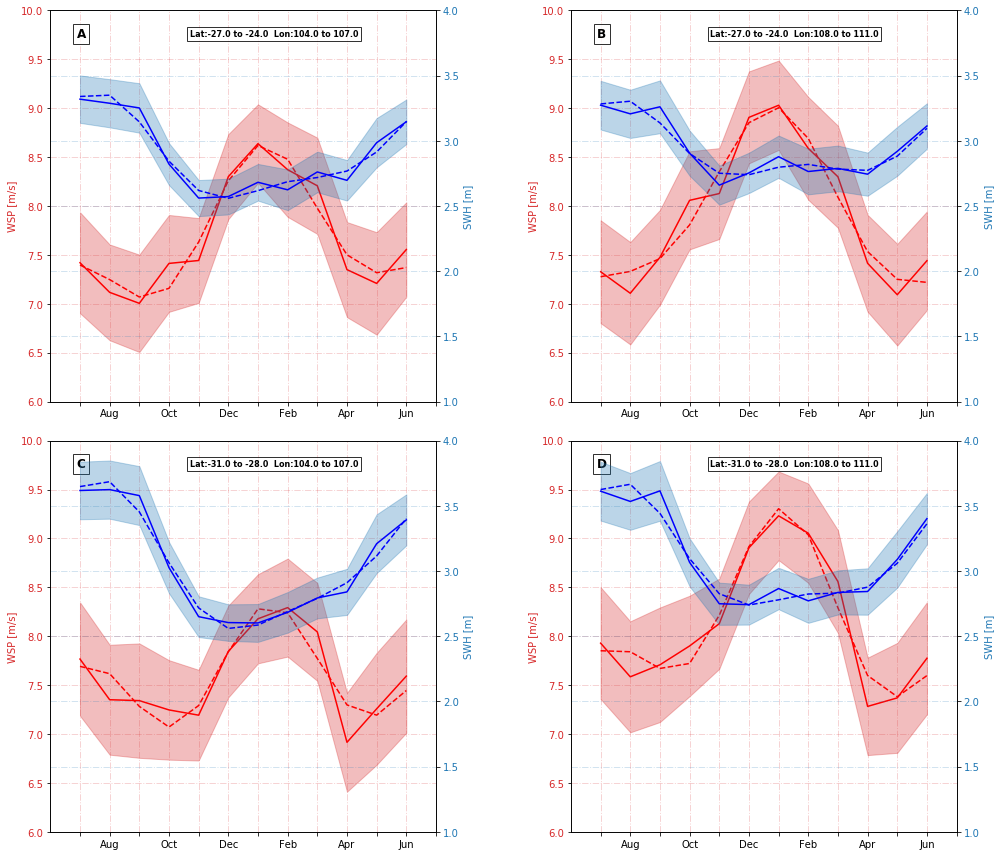

In [29]:
#initialize subplot axes: 
fig, axes = plt.subplots(n_row, n_coln, figsize=(14,12))

#initialize counter: 
gc = 0

#Initialize location sensitive attributes: 
#case 1: 3x3 subplot
if n_row == 3 & n_coln == 3:
    #3 by 3 subplot labels and placement:
    subplot_label = ['G', 'H', 'I', 'D', 'E', 'F', 'A', 'B', 'C']
    subplot_p = [6, 7, 8, 3, 4, 5, 0, 1, 2]
#case 2: 2x2 subplot
elif n_row == 2 & n_coln == 2:
    #2 by 2 subplot labels and placement 
    subplot_label = ['C', 'D', 'A', 'B']
    subplot_p = [2, 3, 0, 1]
#case 3: 1x3 subplot
elif n_row == 1 & n_coln == 3:
    #1 by 3 subplot labels and placement 
    subplot_label = ['A','B','C']
    subplot_p = [0, 1, 2]
    
subplot_label = ['C', 'D', 'A', 'B']
subplot_p = [2, 3, 0, 1]
    
#case 1: NH
if location[0] == 'NH':
    
    #x-axis tick labels for NH:
    time_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
elif location[0] == 'SH':
    
    #x-axis tick labels for SH:
    time_ticks = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']


#loop through several 2 degree by 2 degree grid boxes 
for lat_grid in range(35,41,ngrid):
    for lon_grid in range(104, 112,ngrid):
        
        print(lon_grid, lon_grid+ngrid)
        print(lat_grid, lat_grid+ngrid)
        
        #compute regional climatology: 
        swh_reg_mean_i, swh_reg_stdm_i, swh_hfit_i, swh_residual_i, grid_cor = regional_clima(data_mean = swh_mean_i, data_var = swh_var_i, lon = lon_i, lat = lat_i, lon_grid = lon_grid, lat_grid = lat_grid, ngrid = ngrid, dof = 23, loc = location)
        wsp_reg_mean_c, wsp_reg_stdm_c, wsp_hfit_c, wsp_residual_c, grid_cor = regional_clima(data_mean = wsp_mean_c, data_var = wsp_var_c, lon = lon_i, lat = lat_i, lon_grid = lon_grid, lat_grid = lat_grid, ngrid = ngrid, dof = 23, loc = location)
        swh_reg_mean_w, swh_reg_stdm_w, swh_hfit_w, swh_residual_w, grid_cor = regional_clima(data_mean = swh_mean_w, data_var = swh_var_w, lon = lon_i, lat = lat_i, lon_grid = lon_grid, lat_grid = lat_grid, ngrid = ngrid, dof = 23, loc = location)
        wsp_reg_mean_w, wsp_reg_stdm_w, wsp_hfit_w, wsp_residual_w, grid_cor = regional_clima(data_mean = wsp_mean_w, data_var = wsp_var_w, lon = lon_i, lat = lat_i, lon_grid = lon_grid, lat_grid = lat_grid, ngrid = ngrid, dof = 23, loc = location)
        
        #plot regional climatologies: 
        #call subplot axis: 
        ax_grid = axes.flatten()[subplot_p[gc]]
        
        #SWH axis: 
        ax_grid_twin = ax_grid.twinx()
        #set color of left axis:
        color = 'tab:blue'
        ax_grid_twin.tick_params(axis='y', labelcolor=color)
        #plot WW3
        #ax_grid_twin.plot(month, swh_reg_mean_w, 'k-')
        #ax_grid_twin.fill_between(month, swh_reg_mean_w - swh_reg_stdm_w, swh_reg_mean_w + swh_reg_stdm_w, 
        #                color='black', alpha = 0.3)  
        #Plot Ifremer SWH
        ax_grid_twin.plot(month, swh_reg_mean_i, 'b-')
        ax_grid_twin.plot(month, swh_hfit_i, 'b--')
        ax_grid_twin.fill_between(month, swh_reg_mean_i - swh_reg_stdm_i, swh_reg_mean_i + swh_reg_stdm_i, 
                                  color=color, alpha = 0.3) 
        #Plot residual SWH
        #ax_grid_twin.plot(month, residual_swh, 'b-')
        #ax_grid_twin.set_ylim([-0.5, 0.5])
        #set subplot attributes: 
        ax_grid_twin.set_ylabel('SWH [m]', color=color)
        ax_grid_twin.set_ylim([1, 4])
        ax_grid_twin.grid(color=color, linestyle='-.', linewidth=1, alpha = 0.2)

        #WSP axis:
        #set color:
        color = 'tab:red'
        ax_grid.tick_params(axis='y', labelcolor=color)
        #plot WW3 WSP
        #ax_grid.plot(month, wsp_reg_mean_w, color = 'tab:purple')
        #ax_grid.fill_between(month, wsp_reg_mean_w - wsp_reg_stdm_w, wsp_reg_mean_w + wsp_reg_stdm_w, 
        #                 color='tab:purple', alpha = 0.3)
        #plot CCMP2 WSP
        ax_grid.plot(month, wsp_reg_mean_c, 'r-')
        ax_grid.plot(month, wsp_hfit_c, 'r--')
        ax_grid.fill_between(month, wsp_reg_mean_c - wsp_reg_stdm_c, wsp_reg_mean_c + wsp_reg_stdm_c, 
                             color=color, alpha = 0.3)
        
        #set attributes of subplot: 
        ax_grid.set_xlim([0, 13])
        ax_grid.set_xticklabels(time_ticks)
        start, end = ax_grid.get_xlim()
        ax_grid.xaxis.set_ticks(np.arange(start+1, end+1, 1))
        #hind every other ticklabel
        for label in ax_grid.xaxis.get_ticklabels()[::2]:
            label.set_visible(False)
        ax_grid.set_ylabel('WSP [m/s]', color=color)
        ax_grid.set_ylim([6, 10])
        ax_grid.grid(color=color, linestyle='-.', linewidth=1, alpha = 0.2)
        cart.subplot_label(ax_grid, xdist_label = 0.08, ydist_label = 0.94, 
                           subplot_label = subplot_label[gc], fs_shade = 28, fs_main = 12)
        cart.subplot_label(ax_grid_twin, xdist_label = 0.58, ydist_label = 0.94, 
                           subplot_label = 'Lat:''%s' %grid_cor[0] + ' to ' + '%s' %grid_cor[1] + '  ' + 'Lon:' + '%s' %grid_cor[2] + ' to ' + '%s' %grid_cor[3] , fs_shade = 28, fs_main = 8)
        
        #save data at desire grid box: 
        if subplot_label[gc] == 'D':
            
            np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/west_australia_ifremer', swh_mean = swh_reg_mean_i,
                     swh_stdm = swh_reg_stdm_i, swh_hfit = swh_hfit_i, swh_residual = swh_residual_i, 
                     grid_cor = grid_cor)
            np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/west_australia_ccmp2', wsp_mean = wsp_reg_mean_c, 
                     wsp_stdm = wsp_reg_stdm_c, wsp_hfit = wsp_hfit_c, grid_cor = grid_cor)
            np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/west_australia_ww3', swh_mean = swh_reg_mean_w, 
                     swh_stdm = swh_reg_stdm_w, wsp_mean = wsp_reg_mean_w, wsp_stdm = wsp_reg_stdm_w,  
                     grid_cor = grid_cor)
        
        #sum grid_counter:
        gc += 1
            
        
#make sure the figure looks good:
fig.tight_layout()

#adjust spacing for the entire figure 
plt.subplots_adjust(wspace = 0.35, hspace = 0.1)

#add a legend: 
#plt.figlegend((l1, l2, l3, l4, l5, l6), labels = ('Ifremer SWH', 'Ifremer SWH Least Square fit', 'WW3 SWH', 'CCMP2 WSP', 'CCMP2 WSP least square fit', 'WW3 WSP' ), loc = 'best', ncol=2, labelspacing=0.1)

#save figure: 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/region_clima_fig/west_australia/west_australia_regional_clima_4x4', bbox_inches = 'tight', dpi=300)


Save regional climatology variables in a .npz file for a particular 2x2 degree region

In [ ]:
np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/australia_ifremer', swh_mean = swh_reg_mean_i,
         swh_stdm = swh_reg_stdm_i, swh_hfit = swh_hfit_i, swh_residual = swh_residual_i, grid_cor = grid_cor)
np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/australia_ccmp2', wsp_mean = wsp_reg_mean_c, 
         wsp_stdm = wsp_reg_stdm_c, wsp_hfit = wsp_hfit_c, grid_cor = grid_cor)
np.savez('/zdata/downloads/colosi_data_bk/npz_data/reg_clima/west_australia/australia_ww3', swh_mean = swh_reg_mean_w, 
         swh_stdm = swh_reg_stdm_w, wsp_mean = wsp_reg_mean_w, wsp_stdm = wsp_reg_stdm_w,  grid_cor = grid_cor)

### Development Code

In [ ]:
#latitude and longitude grid points that will be averaged over: 
        lat_grid_i = lat[lat_grid]
        lat_grid_f = lat[lat_grid+ngrid-1]
        lon_grid_i = lon[lon_grid]-360
        lon_grid_f = lon[lon_grid+ngrid-1]-360
        
        #call mean and variance data from grid box indices: 
        swh_grid_mean_i = swh_mean_i[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        wsp_grid_mean_c = wsp_mean_c[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        swh_grid_mean_w = swh_mean_w[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        wsp_grid_mean_w = wsp_mean_w[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        swh_grid_var_i = swh_var_i[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        wsp_grid_var_c = wsp_var_c[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        swh_grid_var_w = swh_var_w[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        wsp_grid_var_w = wsp_var_w[:,lat_grid:(lat_grid+ngrid),lon_grid:(lon_grid+ngrid)]
        
        #average over the region along the column and depth dimension of the 3D array (the row axis is the time dimension): 
        swh_reg_mean_i = np.ma.mean(np.ma.mean(swh_grid_mean_i, axis = 1, dtype=np.float64), axis = 1)
        wsp_reg_mean_c = np.ma.mean(np.ma.mean(wsp_grid_mean_c, axis = 1, dtype=np.float64), axis = 1)
        swh_reg_mean_w = np.ma.mean(np.ma.mean(swh_grid_mean_w, axis = 1, dtype=np.float64), axis = 1)
        wsp_reg_mean_w = np.ma.mean(np.ma.mean(wsp_grid_mean_w, axis = 1, dtype=np.float64), axis = 1)
        
        #compute the average variance over the region 
        swh_reg_var_i = np.ma.mean(np.ma.mean(swh_grid_var_i, axis = 1, dtype=np.float64), axis = 1)
        wsp_reg_var_c = np.ma.mean(np.ma.mean(wsp_grid_var_c, axis = 1, dtype=np.float64), axis = 1)
        swh_reg_var_w = np.ma.mean(np.ma.mean(swh_grid_var_w, axis = 1, dtype=np.float64), axis = 1)
        wsp_reg_var_w = np.ma.mean(np.ma.mean(wsp_grid_var_w, axis = 1, dtype=np.float64), axis = 1)
        
        #compute the standard error of the mean assuming that degrees of freedom N = 23 years
        swh_reg_stdm_i = np.sqrt(swh_reg_var_i)/np.sqrt(23)
        wsp_reg_stdm_c = np.sqrt(wsp_reg_var_c)/np.sqrt(23)
        swh_reg_stdm_w = np.sqrt(swh_reg_var_w)/np.sqrt(23)
        wsp_reg_stdm_w = np.sqrt(wsp_reg_var_w)/np.sqrt(23)
        
        #compute the least square fit: 
        #For Ifremer SWH: 
        swh_hfit, x_swh = least_square_fit(data = swh_reg_mean_i, trend = 'sinusoidal', 
                                           parameters = 5, period = 12, fill_val = 'mask')
        #for CCMP2 WSP: 
        wsp_hfit, x_wsp = least_square_fit(data = wsp_reg_mean_c, trend = 'sinusoidal', 
                                           parameters = 5, period = 12, fill_val = 'mask')
        
        #compute the residue between the model and observed SWH data:
        residual_swh = swh_hfit - swh_reg_mean_i
        
        #If in the southern hemisphere, shift the time series over such that summer months of Dec, Jan, and Feb are center of figure:
#         swh_reg_mean_i = np.reshape(np.ma.array([swh_reg_mean_i[6:13], swh_reg_mean_i[0:6]]), (1,12))[0]
#         wsp_reg_mean_c = np.reshape(np.ma.array([wsp_reg_mean_c[6:13], wsp_reg_mean_c[0:6]]), (1,12))[0]
#         swh_reg_mean_w = np.reshape(np.ma.array([swh_reg_mean_w[6:13], swh_reg_mean_w[0:6]]), (1,12))[0]
#         wsp_reg_mean_w = np.reshape(np.ma.array([wsp_reg_mean_w[6:13], wsp_reg_mean_w[0:6]]), (1,12))[0]
#         swh_reg_stdm_i = np.reshape(np.ma.array([swh_reg_stdm_i[6:13], swh_reg_stdm_i[0:6]]), (1,12))[0]
#         wsp_reg_stdm_c = np.reshape(np.ma.array([wsp_reg_stdm_c[6:13], wsp_reg_stdm_c[0:6]]), (1,12))[0]
#         swh_reg_stdm_w = np.reshape(np.ma.array([swh_reg_stdm_w[6:13], swh_reg_stdm_w[0:6]]), (1,12))[0]
#         wsp_reg_stdm_w = np.reshape(np.ma.array([wsp_reg_stdm_w[6:13], wsp_reg_stdm_w[0:6]]), (1,12))[0]
#         swh_hfit = np.reshape(np.ma.array([swh_hfit[6:13], swh_hfit[0:6]]), (1,12))[0]
#         wsp_hfit = np.reshape(np.ma.array([wsp_hfit[6:13], wsp_hfit[0:6]]), (1,12))[0]

In [ ]:
import numpy as np
a = np.array([(2, 3, 4), (2, 3, 4)])
print(a.shape)
print(a)
a_mean = np.ma.mean(a, axis = 1, dtype=np.float64)
#a_mean = np.ma.mean(np.ma.mean(a, axis = 0, dtype=np.float64), axis=0, dtype=np.float64)
print(a_mean)

In [ ]:
import numpy as np
test_i = np.random.randint(0, 10, size=(2, 5, 4))
print(test_i)
print(test_i[0])
print(test_i[1])
mean_row = np.ma.mean(test_i, axis = 1)
print(mean_row)

In [ ]:
mean_clima = np.ma.mean(mean_row, axis = 0)
print(mean_clima)
print((6+1+1+3+9)/5)
print((4+6+5+6+5)/5)
print((2+4+1+7+4)/5)
print((4+1+4+4+1)/5)

In [ ]:
%whos

In [ ]:
a, b, c = 1, 2, 3
print(a,b,c)
del a, b, c
print(c)

In [ ]:
plt.pcolor(lon_i,lat_i, swh_mean_i[0], vmin=0,vmax=6, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('SWH january mean', fontsize=16)



In [ ]:
gc = 1


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(16,12))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
ax_grid = axes.flatten()[1]
ax_grid.set_title('x')

In [ ]:
6 %2

In [ ]:
print(time_w)

In [ ]:
swh_w.shape

In [ ]:
print(swh_grid_mean_i)
swh_test = np.mean(np.ma.mean(swh_grid_mean_i, axis = 1, dtype=np.float64), axis = 1)
print(swh_test.shape)

In [ ]:
t = [lat_grid, lat_grid+ngrid-1]
p = [lon_grid, lon_grid+ngrid-1]
print(t, p)
swh_test = swh_mean_i[:,92,304:305]
print(swh_test)

In [ ]:
A = np.random.randint(10, size = (12,2,3))
print(A)

In [ ]:
A_grid = A[:,0:1,0:1]
print(A_grid)

In [ ]:
swh_reg_stdm_i

In [ ]:
lat = nc_i.variables['lat'][:]
lon = nc_i.variables['lon'][:]

In [ ]:
print(lon)
lon_n = lon - 180
print(lon_n)
print(lon_n[60])
print(lat[98])
60+180

In [ ]:
import numpy as np
lon_i = np.arange(0,360,1)
print(lon_i[238]-360)

In [ ]:
%whos

In [ ]:
swh_reg_mean_w

In [ ]:
A = np.array([[1, 2, 3, 4 ], [1, 2, 3, 4], [1, 2, 3, 4]])
print(A)
print(A[:,1:3])

In [ ]:
np.array?

In [ ]:
A = np.array([[0:13]])
print(A)

In [ ]:
%whos


In [ ]:
time_ticks


In [ ]:
gc


In [ ]:
n_coln

In [ ]:
subplot_p

In [ ]:
%reset